In [1]:
import pandas as pd
import numpy as np
import argparse
import random
from model import KGCN
from data_loader import DataLoader
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score

In [16]:
# prepare arguments (hyperparameters)
parser = argparse.ArgumentParser()

parser.add_argument("--dataset", type=str, default="music", help="which dataset to use")
parser.add_argument(
    "--aggregator", type=str, default="neighbor", help="which aggregator to use"
)
parser.add_argument("--n_epochs", type=int, default=25, help="the number of epochs")
parser.add_argument(
    "--neighbor_sample_size",
    type=int,
    default=8,
    help="the number of neighbors to be sampled",
)
parser.add_argument(
    "--dim", type=int, default=16, help="dimension of user and entity embeddings"
)
parser.add_argument(
    "--n_iter",
    type=int,
    default=1,
    help="number of iterations when computing entity representation",
)
parser.add_argument("--batch_size", type=int, default=32, help="batch size")
# parser.add_argument('--batch_size', type=int, default=500000, help='batch size')
parser.add_argument(
    "--l2_weight", type=float, default=1e-4, help="weight of l2 regularization"
)
parser.add_argument("--lr", type=float, default=5e-4, help="learning rate")
parser.add_argument("--ratio", type=float, default=0.6, help="size of training dataset")

args = parser.parse_args([])

In [17]:
# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()

Construct knowledge graph ... Done
Build dataset dataframe ... Done


In [18]:
# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]["userID"])
        item_id = np.array(self.df.iloc[idx]["itemID"])
        label = np.array(self.df.iloc[idx]["label"], dtype=np.float32)
        return user_id, item_id, label


In [19]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(
    df_dataset,
    df_dataset["label"],
    test_size=1 - args.ratio,
    shuffle=False,
    random_state=999,
)
x_test, _, y_test, _ = train_test_split(
    x_test, y_test, test_size=0.5, shuffle=False, random_state=999
)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)


In [20]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print("device: ", device)


device:  cuda


In [21]:
# train
loss_list = []
test_loss_list = []
auc_score_list = []
f1_score_list = []

for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = (
            user_ids.to(device),
            item_ids.to(device),
            labels.to(device),
        )
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # print train loss per every epoch
    print("[Epoch {}]".format(epoch + 1))
    print("train_loss: ".format(epoch + 1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))

    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        total_f1 = 0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = (
                user_ids.to(device),
                item_ids.to(device),
                labels.to(device),
            )
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            outputs = outputs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            total_roc += roc_auc_score(labels, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            total_f1 += f1_score(labels, outputs)

        print("test_loss: ".format(epoch + 1), test_loss / len(test_loader))
        print("test_auc: ".format(epoch + 1), total_roc / len(test_loader))
        print("test_f1: ".format(epoch + 1), total_f1 / len(test_loader))
        print("--------------------------------")
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))
        f1_score_list.append(total_f1 / len(test_loader))


[Epoch 1]
train_loss:  0.8959652356596978
test_loss:  0.8235337234892935
test_auc:  0.5054749235210715
test_f1:  0.4997379802769371
--------------------------------
[Epoch 2]
train_loss:  0.7753343631698743
test_loss:  0.7469443139040245
test_auc:  0.5073723431787047
test_f1:  0.49804920419805304
--------------------------------
[Epoch 3]
train_loss:  0.7167597667546356
test_loss:  0.7159144480273408
test_auc:  0.5069476803234295
test_f1:  0.5028367233243717
--------------------------------
[Epoch 4]
train_loss:  0.6953223361926956
test_loss:  0.7051286267784407
test_auc:  0.505744001271976
test_f1:  0.4984348606126158
--------------------------------
[Epoch 5]
train_loss:  0.6876377018182644
test_loss:  0.7010910650469222
test_auc:  0.5054590784812217
test_f1:  0.4980265234593132
--------------------------------
[Epoch 6]
train_loss:  0.6839885524748555
test_loss:  0.6992061068426888
test_auc:  0.5059642311031385
test_f1:  0.49480344170228185
--------------------------------
[Epoch 7]

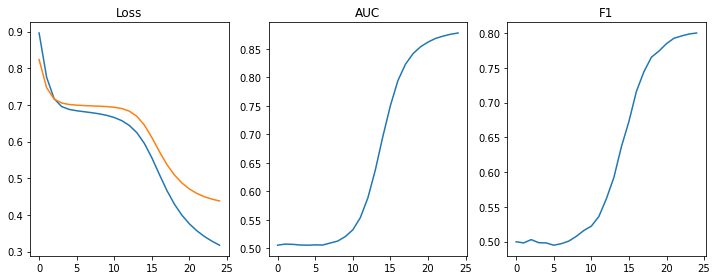

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.plot(loss_list)
ax1.plot(test_loss_list)
ax1.set_title("Loss")
ax2.plot(auc_score_list)
ax2.set_title("AUC")
ax3.plot(f1_score_list)
ax3.set_title("F1")

plt.tight_layout()
